# Medición del Grado de Madurez de una Fruta
Juliana Bermúdez, Sofía Duarte

### Requerimientos (min. 6):
1. **Transformaciones Geométricas y Data Augmentation**
2. **Filtrado y convolución (filtros de suavizado o de borde para resaltar características)**
3. **Detección de bordes y umbralización (Canny, Laplacian, Otsu, etc)**
4. **Ecualización de histogramas**
5. **SIFT, SURF**
6. **Bag of Visual Words o VLAD**
7. **Pipeline ML SkLearn**
8. **Optimización de hiperparámetros**
9. **ML no supervisado (segmentación de color, agrupamiento de texturas, etiquetado automático)**

In [ ]:
# Librerías
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import random

# Las de abajo fueron las que usamos en el pipeline
# Revisar cuáles necesitamos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from itertools import cycle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Lectura de imágenes

In [ ]:
#path_imgs = "/content/drive/MyDrive/Notas Universidad/SEMESTRE 2025-1/Intro a la visión por computadora/Proyecto Corte 2/DeteccionMaduracion_JulianaBermudez_SofiaDuarte/imagenes/"
path_imgs = "/content/drive/MyDrive/UNDERGRADUATE DEGREE/Proyecto Corte 2/DeteccionMaduracion_JulianaBermudez_SofiaDuarte/imagenes/"
img_files = glob.glob(path_imgs+"fotos/*.jpg")
imgs = [cv2.imread(img_file) for img_file in img_files]

In [ ]:
# No todas las imágenes tienen el mismo tamaño
print(imgs[0].shape, imgs[-1].shape)

(3000, 3000, 3) (2992, 2992, 3)


In [ ]:
# Redimensionar para que todas queden de 512X512
imgs = [cv2.resize(imagen, (512, 512), interpolation=cv2.INTER_AREA) for imagen in imgs]
print(imgs[0].shape, imgs[-1].shape)

(512, 512, 3) (512, 512, 3)


## Transformaciones geométricas

Dado que las imágenes no son extraidas de una base de datos, sino recopiladas por nosotras, debemos hacer transformaciones geométricas para aumentar la cantidad. Esto es necesario, dado que los modelos de aprendizaje automático de máquina así lo requieren.

In [ ]:
def trasladar_imagen(imagen, tx, ty):
    filas, columnas = imagen.shape[:2]
    M = np.float32([[1, 0, tx], [0, 1, ty]])  # Matriz de traslación
    return cv2.warpAffine(imagen, M, (columnas, filas))

def escalar_imagen(imagen, escala_x, escala_y):
    return cv2.resize(imagen, None, fx=escala_x, fy=escala_y, interpolation=cv2.INTER_LINEAR)

def rotar_imagen(imagen, angulo):
    filas, columnas = imagen.shape[:2]
    centro = (columnas // 2, filas // 2)  # Centro de la imagen
    M = cv2.getRotationMatrix2D(centro, angulo, 1)  # Matriz de rotación

    # Calcular nuevas dimensiones para evitar recortes
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_width = int((filas * sin) + (columnas * cos))
    new_height = int((filas * cos) + (columnas * sin))

    # Ajustar la matriz de transformación para trasladar la imagen al centro del nuevo lienzo
    M[0, 2] += (new_width - columnas) / 2
    M[1, 2] += (new_height - filas) / 2

    # Aplicar la rotación con el nuevo tamaño
    imagen_rotada = cv2.warpAffine(imagen, M, (new_width, new_height))

    return imagen_rotada

def recortar_negros(imagen):
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    _, umbral = cv2.threshold(gris, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(umbral)
    x, y, w, h = cv2.boundingRect(coords)
    return imagen[y:y+h, x:x+w]

def transformar(imagenes):
    imagenes_transformadas = []

    for imagen in imagenes:
        imagenes_transformadas.append(imagen)

        for tx in [20, 40, 60]:
            for ty in [20, 40, 60]:
                imagen_trasladada = trasladar_imagen(imagen, tx, ty)
                for angulo in [90, 180, 270]:
                    imagen_rotada = rotar_imagen(imagen_trasladada, angulo)
                    imagen_escalada = escalar_imagen(imagen_rotada, 0.5, 0.5)
                    imagen_recortada = recortar_negros(imagen_escalada)
                    imagen_resized = cv2.resize(imagen_recortada, (512, 512), interpolation=cv2.INTER_AREA)
                    imagenes_transformadas.append(imagen_resized)

    return imagenes_transformadas

In [ ]:
imgs_transformadas = transformar(imgs)
print(f"Antes teníamos {len(imgs)} imágenes. Después de las transformaciones tenemos {len(imgs_transformadas)}")


Antes teníamos 36 imágenes. Después de las transformaciones tenemos 1008


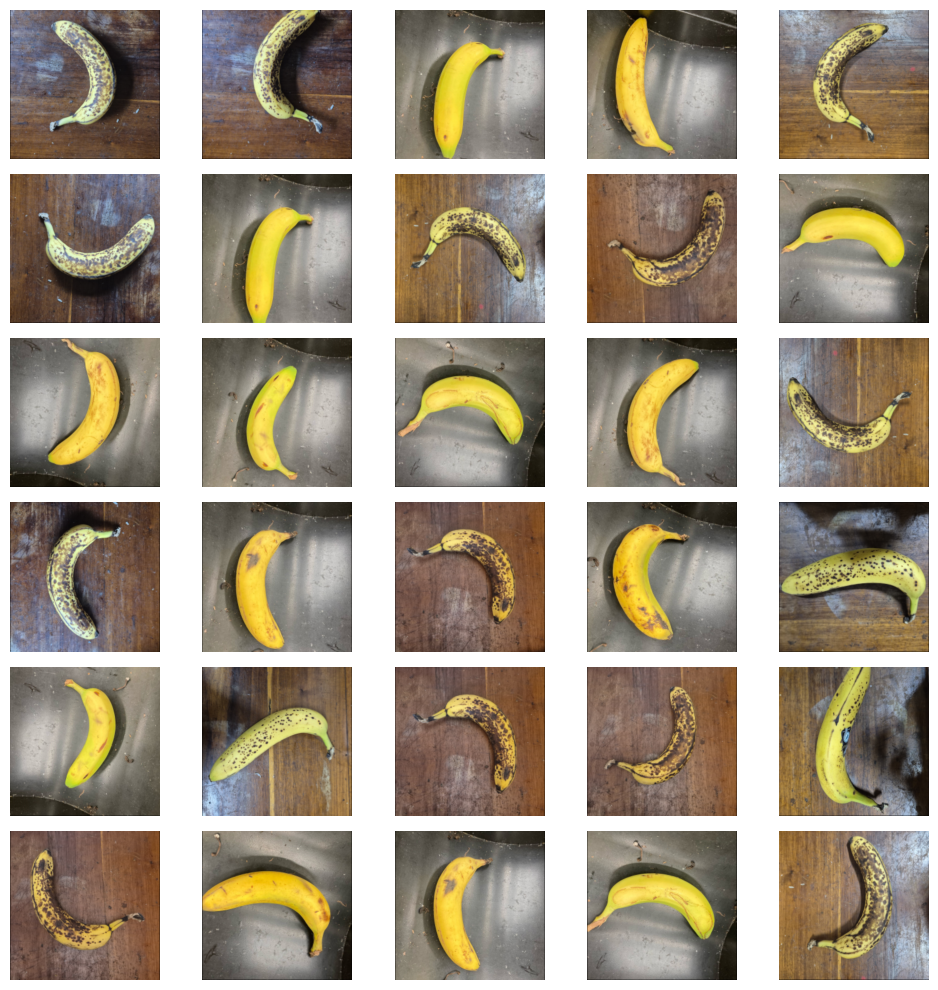

In [ ]:
# Algunas de las imágenes transformadas
imgs_mostrar = random.sample(imgs_transformadas,30)
plt.figure(figsize=(10, 10))
rows, cols = 6, 5
for i, img in enumerate(imgs_mostrar):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Cambiar a RGB para visualización
    plt.axis('off')
plt.tight_layout()
plt.show()

## Filtrado y Convolución

Dado que vamos a aplicar filtros de suavizado y filtros de borde, vamos a generar una función que según el parámetro `tipo_filtro`que se le ingrese, sea capaz de ejecutar cualquiera de las dos categorías.

In [ ]:
def aplicar_filtros(imagenes, tipo_filtro="gaussiano", kernel_size=5):
  imagenes_filtradas = []

  if tipo_filtro == "gaussiano":
    for imagen in imagenes:
      imagenes_filtradas.append(cv2.GaussianBlur(imagen, (kernel_size, kernel_size), 0))

  elif tipo_filtro == "mediana":
    for imagen in imagenes:
      imagenes_filtradas.append(cv2.medianBlur(imagen, kernel_size))

  elif tipo_filtro == "bilateral":
    for imagen in imagenes:
      imagenes_filtradas.append(cv2.bilateralFilter(imagen, 9, 75, 75))  # 9 es el diámetro del píxel de vecindad

  elif tipo_filtro == "sobel":
    for imagen in imagenes:
      grad_x = cv2.Sobel(imagen, cv2.CV_64F, 1, 0, ksize=kernel_size)
      grad_y = cv2.Sobel(imagen, cv2.CV_64F, 0, 1, ksize=kernel_size)
      imagenes_filtradas.append(cv2.convertScaleAbs(cv2.addWeighted(grad_x, 0.5, grad_y, 0.5, 0)))

  elif tipo_filtro == "laplaciano":
    for imagen in imagenes:
      laplaciano = cv2.Laplacian(imagen, cv2.CV_64F, ksize=kernel_size)
      imagenes_filtradas.append(cv2.convertScaleAbs(laplaciano))

  elif tipo_filtro == "canny":
    for imagen in imagenes:
      imagenes_filtradas.append(cv2.Canny(imagen, 50, 150))  # Umbrales para Canny

  else:
      raise ValueError("Tipo de filtro no reconocido. Usa: 'gaussiano', 'mediana', 'bilateral', 'sobel', 'laplaciano', 'canny'.")

  return imagenes_filtradas


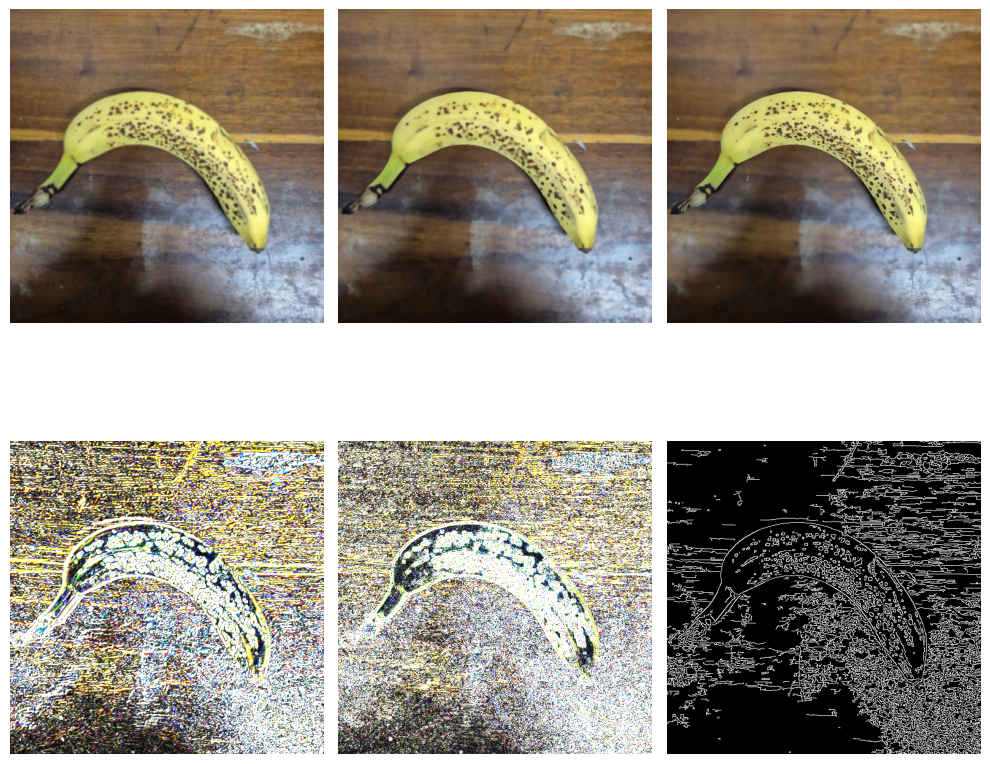

In [ ]:
# Visualización de los efectos de los filtros para una imagen
filtros = ['gaussiano', 'mediana', 'bilateral', 'sobel', 'laplaciano', 'canny']
plt.figure(figsize=(10, 10))
rows, cols = 2, 3
for i, filtro in enumerate(filtros):
  imagen_filtrada = aplicar_filtros([imgs_transformadas[0]], tipo_filtro=filtro, kernel_size=5)[0]
  plt.subplot(rows, cols, i + 1)
  plt.imshow(cv2.cvtColor(imagen_filtrada, cv2.COLOR_BGR2RGB)) # Cambiar a RGB para visualización
  plt.axis('off')
plt.tight_layout()
plt.show()

## Detección de bordes y umbralización

In [ ]:
def detectar_bordes(imagenes, metodo="canny", umbral1=50, umbral2=150):
  imagenes_bordes = []
  # Aplicar detección de bordes
  for imagen in imagenes:
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    if metodo == "canny":
        bordes = cv2.Canny(imagen_gris, umbral1, umbral2)
    elif metodo == "sobel":
        grad_x = cv2.Sobel(imagen_gris, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(imagen_gris, cv2.CV_64F, 0, 1, ksize=3)
        bordes = cv2.convertScaleAbs(cv2.addWeighted(grad_x, 0.5, grad_y, 0.5, 0))
    elif metodo == "laplaciano":
        laplaciano = cv2.Laplacian(imagen_gris, cv2.CV_64F, ksize=3)
        bordes = cv2.convertScaleAbs(laplaciano)
    else:
        raise ValueError("Método no reconocido. Usa: 'canny', 'sobel', 'laplaciano'.")
    # Convertir bordes a 3 canales para superponer en la imagen original
    bordes_color = cv2.cvtColor(bordes, cv2.COLOR_GRAY2BGR)

    # Superponer bordes sobre la imagen original (usando una máscara)
    imagenes_bordes.append(cv2.addWeighted(imagen, 0.8, bordes_color, 0.5, 0))

  return imagenes_bordes


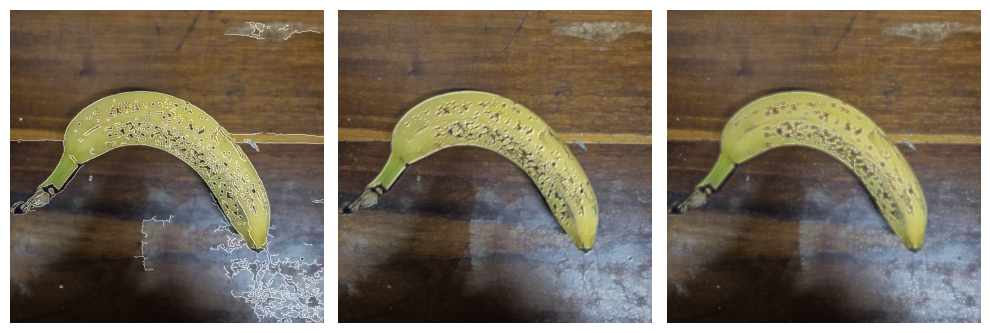

In [ ]:
# Visualización de los efectos de la detección de bordes para una imagen filtrada
imagenes_filtradas = aplicar_filtros(imgs_transformadas)
metodos = ["canny", "sobel", "laplaciano"]
plt.figure(figsize=(10, 10))
rows, cols = 1, 3
for i, metodo in enumerate(metodos):
  imagen_bordes = detectar_bordes([imagenes_filtradas[0]], metodo=metodo)[0]
  plt.subplot(rows, cols, i + 1)
  plt.imshow(cv2.cvtColor(imagen_bordes, cv2.COLOR_BGR2RGB)) # Cambiar a RGB para visualización
  plt.axis('off')
plt.tight_layout()
plt.show()

## Ecualización de histogramas

In [ ]:
def ecualizar_histogramas(imagenes, metodo="CLAHE"):
  imagenes_ecualizadas = []
  for imagen in imagenes:
      # Convertimos la imagen a espacio LAB (mejor para ecualización)
      lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)

      # Separar los canales L (luminosidad), A y B (color)
      l, a, b = cv2.split(lab)

      if metodo == "normal":
          # Ecualización estándar del canal de luminosidad
          l_ecualizada = cv2.equalizeHist(l)
      elif metodo == "CLAHE":
          # Ecualización adaptativa (mejor para evitar sobreexposición)
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
          l_ecualizada = clahe.apply(l)
      else:
          raise ValueError("Método no reconocido. Usa 'normal' o 'CLAHE'.")

      # Fusionamos los canales de vuelta
      lab_ecualizado = cv2.merge((l_ecualizada, a, b))

      # Convertimos de nuevo a BGR
      imagenes_ecualizadas.append(cv2.cvtColor(lab_ecualizado, cv2.COLOR_LAB2BGR))

  return imagenes_ecualizadas

In [ ]:
# Visualización de los efectos de la ecualización para una imagen umbralizada
imagenes_bordes = detectar_bordes(imagenes_filtradas, metodo="canny")
metodos = ["normal", "CLAHE"]
plt.figure(figsize=(10, 10))
rows, cols = 1, 2
for i, metodo in enumerate(metodos):
  imagen_ecualizada = ecualizar_histogramas([imagenes_bordes[0]], metodo=metodo)[0]
  plt.subplot(rows, cols, i + 1)
  plt.imshow(cv2.cvtColor(imagen_ecualizada, cv2.COLOR_BGR2RGB)) # Cambiar a RGB para visualización
  plt.axis('off')
plt.tight_layout()
plt.show()

## Extracción de características

In [ ]:
def extraer_descriptores(imagenes, drawKeypoints=False):
    sift = cv2.SIFT_create()
    descriptores = []

    for idx, img in enumerate(imagenes):
        keypoints, descriptors = sift.detectAndCompute(img, None)

        if drawKeypoints:
            img_kp = cv2.drawKeypoints(img, keypoints, None)
            plt.imshow(img_kp)
            plt.title(f"Image {idx} - {len(keypoints)} keypoints")
            plt.show()

        if descriptors is not None:
            descriptores.append(descriptors)
        else:
            print(f"No descriptors for image {idx}")
            descriptores.append(None)

    return descriptores


In [ ]:
# Visualización de la extracción de keypoints para una imagen ecualizada
imagenes_ecualizadas = ecualizar_histogramas(imagenes_bordes, metodo="CLAHE")
descriptores = extraer_descriptores(imagenes_ecualizadas, drawKeypoints=True)

## Vectorización de imágenes

In [ ]:
def calcular_vlad(descriptores, num_clusters=32):
    # Quitamos los vacíos
    descriptores_validos = [d for d in descriptores if d is not None and len(d) > 0]

    if len(descriptores_validos) == 0:
        print("No valid descriptors found. VLAD will return empty.")
        return []

    # Stack de todos los descriptores para el clustering
    all_des = np.vstack(descriptores_validos)

    # Hacemos KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(all_des)

    vlad_vectors = []

    for d in descriptores:
        if d is None or len(d) == 0:
            # Vector cero si no hay descriptores
            vlad = np.zeros((num_clusters, all_des.shape[1]))
        else:
            predicted_labels = kmeans.predict(d)
            vlad = np.zeros((num_clusters, d.shape[1]))
            for i in range(len(d)):
                #Sumamos las distancias de los descriptores a los centroides
                vlad[predicted_labels[i]] += d[i] - kmeans.cluster_centers_[predicted_labels[i]]
        vlad_vectors.append(vlad.flatten())  # Flatten here!

    return np.array(vlad_vectors)


In [ ]:
# Calculamos el vector VLAD para las imágenes
vectores_vlad = calcular_vlad(descriptores)
print(vectores_vlad.shape)
vectores_vlad[0][:20]

(1008, 4096)


array([ -87.32200813,  106.22160339,  672.2508297 ,  312.30357742,
        -54.40670776,  121.34465408, -110.47347164, -136.17314529,
       -377.76977539, -131.68210602,  205.18789673,  698.61120224,
        607.39872932,  490.46269226, -106.38373947, -271.91169739,
       -268.05516052, -165.13264084,   65.14090919,   65.5066309 ])

## Etiquetado automático

In [ ]:
def etiquetado_automatico(vectores_vlad, num_etiquetas=3):
    vectores_vlad = np.array(vectores_vlad).reshape(len(vectores_vlad), -1)
    kmeans = KMeans(n_clusters=num_etiquetas, random_state=42, n_init=10)
    etiquetas = kmeans.fit_predict(vectores_vlad)
    return etiquetas  # or return etiquetas, kmeans if you need the model


In [ ]:
etiquetas = etiquetado_automatico(vectores_vlad)
print(etiquetas.shape)
etiquetas[:20]

(1008,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [ ]:
idx_mostrar = random.sample(range(len(etiquetas)), 30)
plt.figure(figsize=(10, 10))
rows, cols = 6, 5
for i, j in enumerate(idx_mostrar):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(imgs_transformadas[j], cv2.COLOR_BGR2RGB)) # Cambiar a RGB para visualización
    plt.title(f"Etiqueta asignada: {etiquetas[j]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Pipeline de Machine Learning

In [ ]:
IMAGE_FOLDER = "/content/drive/MyDrive/UNDERGRADUATE DEGREE/Proyecto Corte 2/DeteccionMaduracion_JulianaBermudez_SofiaDuarte/imagenes/fotos"
#IMAGE_FOLDER = "/content/drive/MyDrive/Notas Universidad/SEMESTRE 2025-1/Intro a la visión por computadora/Proyecto Corte 2/DeteccionMaduracion_JulianaBermudez_SofiaDuarte/imagenes/fotos"

In [ ]:
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, folder, size=(512, 512)):
        self.folder = folder
        self.size = size

    def fit(self, X=None, y=None): return self

    def transform(self, X=None):
        import glob, cv2
        import os
        img_files = glob.glob(os.path.join(self.folder, "*.jpg"))
        return [cv2.resize(cv2.imread(img), self.size) for img in img_files]

class TransformadorGeometrico(BaseEstimator, TransformerMixin):
    def __init__(self, traslaciones=[20, 40, 60], angulos=[90, 180, 270], escala=(0.5, 0.5), output_size=(512, 512)):
        self.traslaciones = traslaciones
        self.angulos = angulos
        self.escala = escala
        self.output_size = output_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self._transformar(X)

    def _trasladar_imagen(self, imagen, tx, ty):
        filas, columnas = imagen.shape[:2]
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(imagen, M, (columnas, filas))

    def _escalar_imagen(self, imagen, escala_x, escala_y):
        return cv2.resize(imagen, None, fx=escala_x, fy=escala_y, interpolation=cv2.INTER_LINEAR)

    def _rotar_imagen(self, imagen, angulo):
        filas, columnas = imagen.shape[:2]
        centro = (columnas // 2, filas // 2)
        M = cv2.getRotationMatrix2D(centro, angulo, 1)

        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        new_width = int((filas * sin) + (columnas * cos))
        new_height = int((filas * cos) + (columnas * sin))

        M[0, 2] += (new_width - columnas) / 2
        M[1, 2] += (new_height - filas) / 2

        return cv2.warpAffine(imagen, M, (new_width, new_height))

    def _recortar_negros(self, imagen):
        gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        _, umbral = cv2.threshold(gris, 1, 255, cv2.THRESH_BINARY)
        coords = cv2.findNonZero(umbral)
        x, y, w, h = cv2.boundingRect(coords)
        return imagen[y:y+h, x:x+w]

    def _transformar(self, imagenes):
        imagenes_transformadas = []

        for imagen in imagenes:
            imagenes_transformadas.append(imagen)  # Original

            for tx in self.traslaciones:
                for ty in self.traslaciones:
                    imagen_trasladada = self._trasladar_imagen(imagen, tx, ty)
                    for angulo in self.angulos:
                        imagen_rotada = self._rotar_imagen(imagen_trasladada, angulo)
                        imagen_escalada = self._escalar_imagen(imagen_rotada, *self.escala)
                        imagen_recortada = self._recortar_negros(imagen_escalada)
                        imagen_resized = cv2.resize(imagen_recortada, self.output_size, interpolation=cv2.INTER_AREA)
                        imagenes_transformadas.append(imagen_resized)

        return imagenes_transformadas

class FiltroAplicador(BaseEstimator, TransformerMixin):
    def __init__(self, tipo_filtro="gaussiano", kernel_size=5):
        self.tipo_filtro = tipo_filtro
        self.kernel_size = kernel_size

    def fit(self, X, y=None): return self

    def transform(self, X):
        return aplicar_filtros(X, tipo_filtro=self.tipo_filtro, kernel_size=self.kernel_size)

class DetectorBordes(BaseEstimator, TransformerMixin):
    def __init__(self, metodo="canny", umbral1=50, umbral2=150):
        self.metodo = metodo
        self.umbral1 = umbral1
        self.umbral2 = umbral2

    def fit(self, X, y=None): return self

    def transform(self, X):
        return detectar_bordes(X, metodo=self.metodo, umbral1=self.umbral1, umbral2=self.umbral2)

class EcualizadorHistograma(BaseEstimator, TransformerMixin):
    def __init__(self, metodo="CLAHE"):
        self.metodo = metodo

    def fit(self, X, y=None): return self

    def transform(self, X):
        return ecualizar_histogramas(X, metodo=self.metodo)

class ExtractorDescriptores(BaseEstimator, TransformerMixin):
    def __init__(self, drawKeypoints=False):
        self.drawKeypoints = drawKeypoints

    def fit(self, X, y=None): return self

    def transform(self, X):
        return extraer_descriptores(X, drawKeypoints=self.drawKeypoints)

class VLADEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, num_clusters=32):
        self.num_clusters = num_clusters

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vlad_vectors = calcular_vlad(X, num_clusters=self.num_clusters)
        vlad_vectors = [vec.flatten() for vec in vlad_vectors]  # Flatten each vector
        return np.array(vlad_vectors)

class EtiquetadorAutomatico(BaseEstimator, TransformerMixin):
    def __init__(self, num_etiquetas=3):
        self.num_etiquetas = num_etiquetas
        self.kmeans = None

    def fit(self, X, y=None):
        X = np.array(X).reshape(len(X), -1)
        self.kmeans = KMeans(n_clusters=self.num_etiquetas, random_state=42, n_init=10)
        self.kmeans.fit(X)
        return self

    def transform(self, X):
        X = np.array(X).reshape(len(X), -1)
        etiquetas = self.kmeans.predict(X)
        return etiquetas  # shape (n_samples,)

In [ ]:
pipeline_preprocesamiento = Pipeline([
    ('load', ImageLoader(folder  = IMAGE_FOLDER)),
    ('transformaciones', TransformadorGeometrico()),
    ('suavizado', FiltroAplicador()),
    ('umbralizacion', DetectorBordes()),
    ('ecualizacion', EcualizadorHistograma()),
    ('extraccion', ExtractorDescriptores()),
    ('vectorizacion', VLADEncoder()),
])


features = pipeline_preprocesamiento.fit_transform(None)


In [ ]:
features.shape

(1008, 4096)

In [ ]:
pipeline_etiquetado = Pipeline([
    ('etiquetado', EtiquetadorAutomatico()),
])

etiquetas = pipeline_etiquetado.fit_transform(features)


In [ ]:
etiquetas.shape

(1008,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, etiquetas, test_size=0.2, random_state=42)

In [ ]:
model = XGBClassifier(use_label_encoder=False,
                      eval_metric='mlogloss',
                      tree_method='hist',
                      device = "gpu" # Activamos el uso de GPU para acelerar el entrenamiento
                      )
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:56:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:56:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:56:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.995049504950495
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.99      1.00      0.99        69
           2       1.00      1.00      1.00       112

    accuracy                           1.00       202
   macro avg       1.00      0.98      0.99       202
weighted avg       1.00      1.00      1.00       202



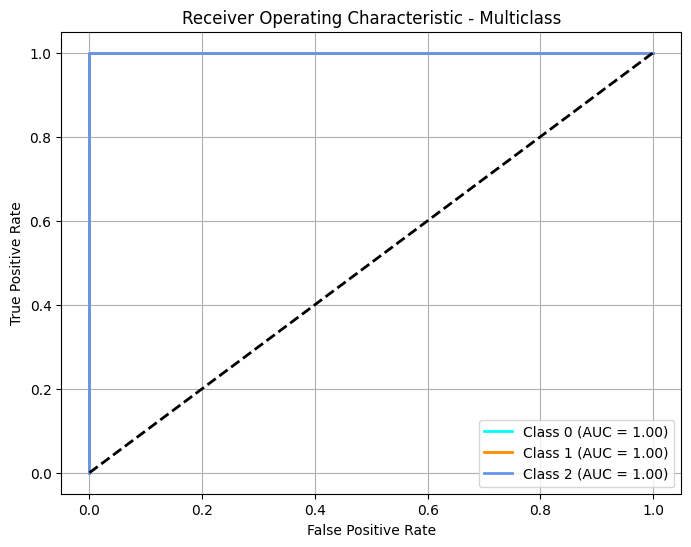

In [ ]:
# Binarizar los labels
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_test)

# Encontrar ROCs
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar curvas
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multiclass')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

y_bin = label_binarize(y, classes=np.unique(y))  # if needed
aucs = cross_val_score(model, X, y, scoring='roc_auc_ovr', cv=5)
print("Cross-validated AUC scores:", aucs)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:01:43] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:01:43] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:01:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:02:26] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:02:26] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  w

Cross-validated AUC scores: [1.         0.99996124 1.         1.         1.        ]


## Optimización de hiperparámetros

In [ ]:
# Tomamos una muestra de los datos para acelerar el proceso
X_sample, _, y_sample, _ = train_test_split(features, etiquetas, test_size=0.8, random_state=42, stratify=etiquetas)

# Diccionario para guardar los mejores resultados
mejores_resultados = {}

# Grids por booster
grids_por_booster = {
    'gbtree': {
        'booster': ['gbtree'],
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    },
    'dart': {
        'booster': ['dart'],
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1],
        'rate_drop': [0.1, 0.2],
        'skip_drop': [0.1, 0.5]
    },
    'gblinear': {
        'booster': ['gblinear'],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [50, 100],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 10]
    }
}

# Entrenar un GridSearch para cada booster
for booster, param_grid in grids_por_booster.items():
    print(f"\n Buscando hiperparámetros para booster: {booster}")

    # Clasificador inicial
    usar_gpu = booster != 'gblinear' # el único método que no usa GPU es gblinear
    xgb = XGBClassifier(objective='multi:softmax',
                        num_class=3,
                        eval_metric='mlogloss',
                        use_label_encoder=False,
                        tree_method='hist' if usar_gpu else 'auto',
                        device = "gpu" if usar_gpu else "cpu"
                        )

    grid_search = GridSearchCV(estimator=xgb,
                               param_grid=param_grid,
                               cv=5,
                               scoring='accuracy',
                               verbose=1,
                               n_jobs=-1)

    grid_search.fit(X_sample, y_sample)

    print(f"\n Mejor configuración para {booster}:")
    print(grid_search.best_params_)

    mejores_resultados[booster] = {
        'mejores_parametros': grid_search.best_params_,
        'mejor_score': grid_search.best_score_,
        'modelo_entrenado': grid_search.best_estimator_
    }

# Comparar todos los boosters
print("\n Comparativa general:")
for booster, resultado in mejores_resultados.items():
    print(f"Booster: {booster} - Accuracy: {resultado['mejor_score']:.4f}")



 Buscando hiperparámetros para booster: gbtree
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Mejor configuración para gbtree:
{'booster': 'gbtree', 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

 Buscando hiperparámetros para booster: dart
Fitting 5 folds for each of 128 candidates, totalling 640 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:31:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Mejor configuración para dart:
{'booster': 'dart', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'rate_drop': 0.1, 'skip_drop': 0.1, 'subsample': 0.8}

 Buscando hiperparámetros para booster: gblinear
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:33:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "tree_method", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Mejor configuración para gblinear:
{'booster': 'gblinear', 'learning_rate': 0.05, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1}

 Comparativa general:
Booster: gbtree - Accuracy: 0.9850
Booster: dart - Accuracy: 0.9850
Booster: gblinear - Accuracy: 1.0000
